## Plotting + Choosing Colors

### Setup:
* In python 3.8.5 virtualenv:
`pip install matplotlib numpy colormath colormap easydev jupyterlab jupyter`
* Install and setup tk
  * This worked for me on Catalina with pyenv: https://github.com/pyenv/pyenv/issues/1375#issuecomment-673144925

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from colormath.color_objects import LabColor, sRGBColor, AppleRGBColor
from colormath.color_conversions import convert_color
from colormap import rgb2hex, hex2rgb

RAINBOW = {
    "R": "red",
    "O": "orange",
    "Y": "yellow",
    "G": "green",
    "B": "blue",
    "P": "pink", # indigo is stupid
    "V": "purple"
}

FILEPATH = "./clicked_colors.txt"

In [2]:
def get_color_maps():
    '''This function converts CIELAB colors to RGB
    colors for plotting'''
    data = {}
    for L in (30, 40, 50, 60, 70, 80, 85, 90, 95):
#     for L in range(60, 70a, 10):
        print(f"Brightness [L]: {L}")
        red = np.empty((256, 256))
        green = np.empty((256, 256))
        blue = np.empty((256, 256))
        for xx, a in enumerate(range(-128, 128)):
            for yy, b in enumerate(range(-128, 128)):
                lab = LabColor(L, a, b)
                rgb = convert_color(color=lab, target_cs=sRGBColor)
                red[yy, xx], green[yy, xx], blue[yy, xx] = rgb.get_value_tuple()

        oob_mask = (red > 1) | (blue > 1) | (green > 1)
        red[oob_mask] = blue[oob_mask] = green[oob_mask] = np.nan
        plot_matrix = np.dstack((np.flipud(red), np.flipud(green), np.flipud(blue)))
        data[L] = plot_matrix
    return data

In [3]:
# data = get_color_maps()

Brightness [L]: 30
Brightness [L]: 40
Brightness [L]: 50
Brightness [L]: 60
Brightness [L]: 70
Brightness [L]: 80
Brightness [L]: 85
Brightness [L]: 90
Brightness [L]: 95


In [4]:
# %store data

Stored 'data' (dict)


In [5]:
%store -r data

In [6]:
def plot_clickable(data, L, c1, c2, num_clicks):
    global clicks
    clicks = 0
    file = open(FILEPATH, "a+")
    comp = f"{RAINBOW[c1].title()}/{RAINBOW[c2].title()}"

    plot_matrix = data[L]
    fig, ax = plt.subplots(figsize=(24, 14))

    def onclick(event):
        global clicks # bad in general, fine here
        if clicks == 0:
            file.write(f"\n# L={L}, {comp}\n")
        clicks += 1
        file.write(f'(({L}, {event.xdata}, {event.ydata}), ("{c1}", "{c2}")),\n')
        if (clicks == num_clicks):
            plt.close()
            file.close()
            return
        ax.set_title(f"LAB Colors in sRGB (L = {L}, {comp}, {clicks}/{num_clicks})", fontsize=18)
        plt.show() # updates title, slow but w/e
        file.flush()

    ax.imshow(plot_matrix, extent=(-128, 128, -128, 128))
    ax.set_title(f"LAB Colors in sRGB (L = {L}, {comp}, {clicks}/{num_clicks})", fontsize=18)
    ax.set_xlabel("a axis", fontsize=18)
    ticks = np.linspace(-128, 128, 16, dtype=int)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks)
    ax.set_ylabel("b axis", fontsize=18)
    ax.grid(alpha=0.3)

    fig.canvas.mpl_connect('button_press_event', onclick)
    plt.show()

In [129]:
%matplotlib tk
clicks = 0 # must declare before making global later

NUM_CLICKS = 4
L = 50 # min 40

In [105]:
plot_clickable(data, L, "B", "G", NUM_CLICKS)

In [29]:
plot_clickable(data, L, "G", "Y", NUM_CLICKS)

In [118]:
plot_clickable(data, L, "Y", "O", NUM_CLICKS)

In [61]:
plot_clickable(data, L, "O", "R", NUM_CLICKS)

In [79]:
plot_clickable(data, L, "R", "P", NUM_CLICKS)

In [130]:
plot_clickable(data, L, "P", "V", NUM_CLICKS) #

In [97]:
plot_clickable(data, L, "V", "B", NUM_CLICKS) #

In [15]:
def plot_maps(data):
    '''This function takes in L -> (RGB_matrices) mappings
    and plots the CIELAB colormap in sRGB'''
    for L, plot_matrix in data.items():
        fig, ax = plt.subplots(figsize=(16, 9))
        ax.imshow(plot_matrix, extent=(-128, 128, -128, 128))
        ax.set_title(f"LAB Colors Plotted in sRGB (L = {L})", fontsize=18)
        ax.set_xlabel("a axis", fontsize=18)
        ticks = np.linspace(-128, 128, 16, dtype=int)
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks)
        ax.set_yticks(ticks)
        ax.set_yticklabels(ticks)
        ax.set_ylabel("b axis", fontsize=18)
        ax.grid(alpha=0.3)
        plt.show()
        plt.close()

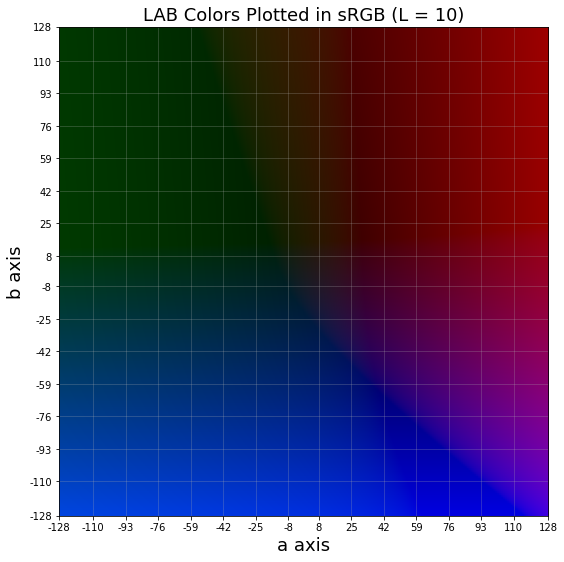

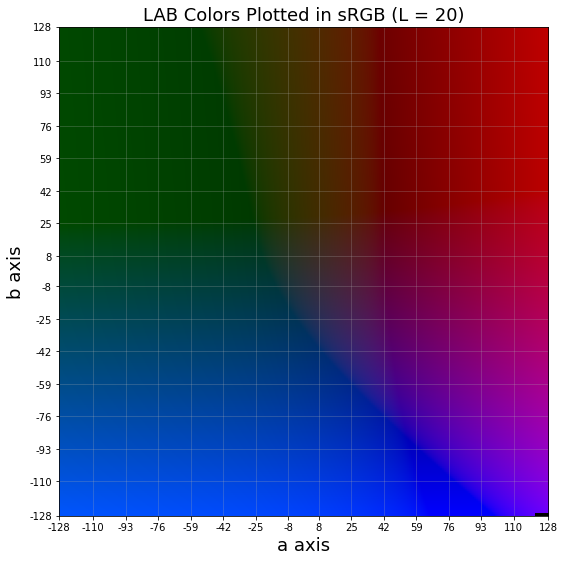

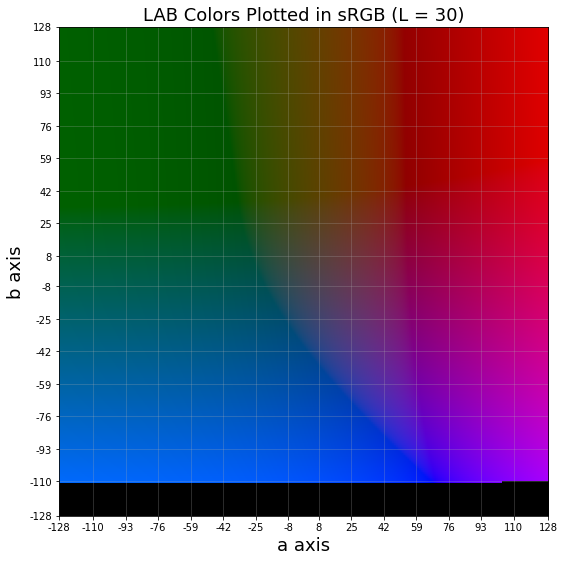

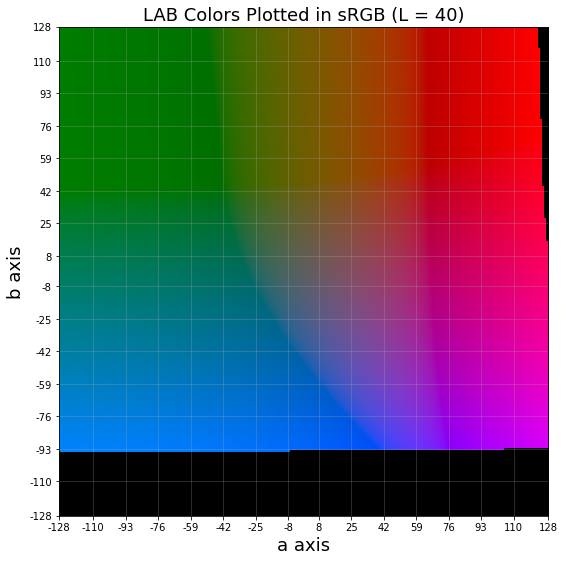

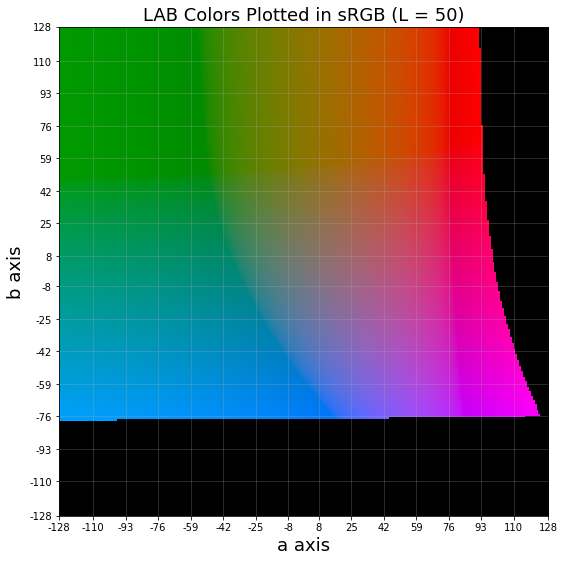

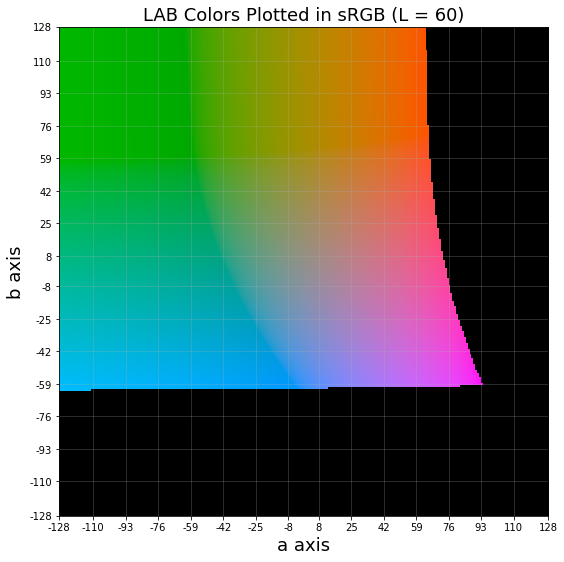

KeyboardInterrupt: 

In [16]:
%matplotlib inline
plot_maps(data)

In [3]:
def parse_colors():
    '''Parses choices in to RGB + two color options'''
    from ast import literal_eval
    colors = []
    file = open(FILEPATH, 'r')
    for color in file:
        color = color.strip()
        if color == '' or color.startswith("#"): continue
        color = literal_eval(color[:-1]) # trailing comma
        lab = LabColor(*color[0])
        rgb = convert_color(color=lab, target_cs=sRGBColor)
        rgb_vals = rgb.get_value_tuple()
        if (rgb_vals[0] > 1 or rgb_vals[1] > 1 or rgb_vals[2] > 1):
            print(f"Skipping {color}")
            print(f"\t{rgb_vals}")
            continue
        
        first_option = RAINBOW[color[1][0]]
        second_option = RAINBOW[color[1][1]]
        colors.append({
            "hex": rgb2hex(*rgb_vals, normalised=True),
            "first_option": first_option,
            "second_option": second_option
        })
    return colors

In [12]:
output = parse_colors()
for color in output:
    print(f"INSERT INTO color (hex, first_option, second_option) VALUES ('{color['hex']}', '{color['first_option']}', '{color['second_option']}') RETURNING id;")
print(len(output))
output

INSERT INTO color (hex, first_option, second_option) VALUES ('#009CBB', 'blue', 'green') RETURNING id;
INSERT INTO color (hex, first_option, second_option) VALUES ('#009BAE', 'blue', 'green') RETURNING id;
INSERT INTO color (hex, first_option, second_option) VALUES ('#009B9D', 'blue', 'green') RETURNING id;
INSERT INTO color (hex, first_option, second_option) VALUES ('#009A8E', 'blue', 'green') RETURNING id;
INSERT INTO color (hex, first_option, second_option) VALUES ('#00B9CF', 'blue', 'green') RETURNING id;
INSERT INTO color (hex, first_option, second_option) VALUES ('#00B9C4', 'blue', 'green') RETURNING id;
INSERT INTO color (hex, first_option, second_option) VALUES ('#00B8B3', 'blue', 'green') RETURNING id;
INSERT INTO color (hex, first_option, second_option) VALUES ('#00B8A3', 'blue', 'green') RETURNING id;
INSERT INTO color (hex, first_option, second_option) VALUES ('#00D8E4', 'blue', 'green') RETURNING id;
INSERT INTO color (hex, first_option, second_option) VALUES ('#00D7D8', '

[{'hex': '#009CBB', 'first_option': 'blue', 'second_option': 'green'},
 {'hex': '#009BAE', 'first_option': 'blue', 'second_option': 'green'},
 {'hex': '#009B9D', 'first_option': 'blue', 'second_option': 'green'},
 {'hex': '#009A8E', 'first_option': 'blue', 'second_option': 'green'},
 {'hex': '#00B9CF', 'first_option': 'blue', 'second_option': 'green'},
 {'hex': '#00B9C4', 'first_option': 'blue', 'second_option': 'green'},
 {'hex': '#00B8B3', 'first_option': 'blue', 'second_option': 'green'},
 {'hex': '#00B8A3', 'first_option': 'blue', 'second_option': 'green'},
 {'hex': '#00D8E4', 'first_option': 'blue', 'second_option': 'green'},
 {'hex': '#00D7D8', 'first_option': 'blue', 'second_option': 'green'},
 {'hex': '#00D7C8', 'first_option': 'blue', 'second_option': 'green'},
 {'hex': '#00D6B5', 'first_option': 'blue', 'second_option': 'green'},
 {'hex': '#00F6E7', 'first_option': 'blue', 'second_option': 'green'},
 {'hex': '#00F5D8', 'first_option': 'blue', 'second_option': 'green'},
 {'hex

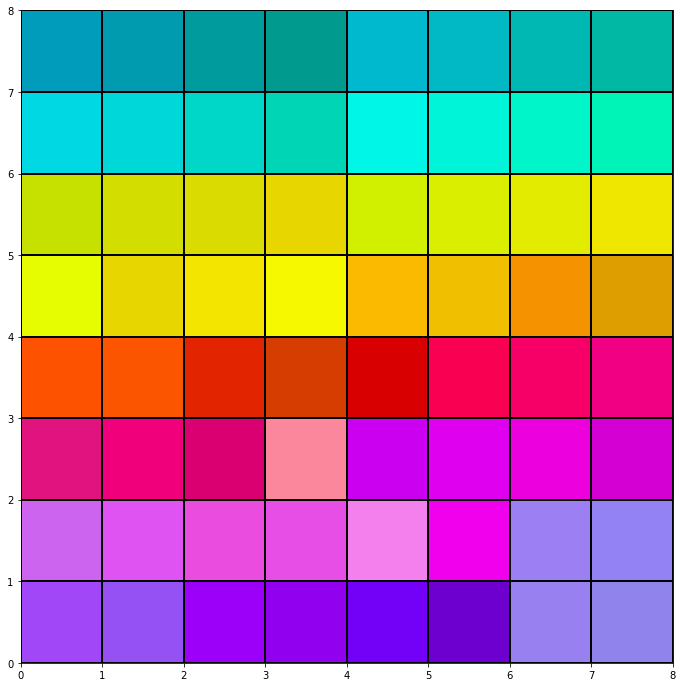

In [132]:
%matplotlib inline
vals = []
square_len = int(np.ceil(np.sqrt(len(output))))
for colnum in range(square_len):
    row = []
    for rownum in range(square_len):
        idx = colnum * square_len + rownum
        if idx < len(output):
            color = output[colnum * square_len + rownum]['hex'] 
        else:
            color = "#000000"
        row.append(hex2rgb(color))
    vals.append(row)
    
fig, ax = plt.subplots(figsize=(24,12))
# ax.imshow(np.dstack([[1.1322109325388734], [0.0], [0.2365099272000714]]))
ax.imshow(np.array(vals), extent=(0, square_len, 0, square_len))
ax.set_xticks(range(0, square_len+1))
ax.set_yticks(range(0, square_len+1))
ax.grid(color='k', lw=2)
plt.show()

In [ ]:
plot_clickable(data, L, "B", "G", NUM_CLICKS)

In [ ]:
plot_clickable(data, L, "G", "Y", NUM_CLICKS)

In [ ]:
plot_clickable(data, L, "Y", "O", NUM_CLICKS)

In [ ]:
plot_clickable(data, L, "O", "R", NUM_CLICKS)

In [ ]:
plot_clickable(data, L, "R", "P", NUM_CLICKS)

In [ ]:
plot_clickable(data, L, "P", "V", NUM_CLICKS) #

In [ ]:
plot_clickable(data, L, "V", "B", NUM_CLICKS) #